In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import statsmodels.stats.multitest as smm
from scipy import stats
import seaborn as sns

from Bio import Seq

pd.options.mode.chained_assignment = None

#makes viewing pandas tables better
pd.set_option('display.max_colwidth', 0)

Change the following parameters to your output directory (where you want output files to be written), your metafile, and TNseq output. 

If these files aren't in the same directory as this notebook, you need use the full path. For example, the full path of 'barseq_output' would be '/usr2/people/clairedubin/barseq/barseq_output'

Also change the control and experimental temperatures if needed.

In [2]:
#where the BarSeq FASTQs are
FASTQ_directory = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024'


## Barseq metafile

You'll need to create your own metafile - easiest way is edit in Excel. A sample metafile is located at: /usr2/people/clairedubin/barseq/Kluyv_BarSeq_metadata.txt

    Fastq: path to barseq FASTQ for each competition
    SampleName: unique name for each competition, MUST include ctrl_temp or exp_temp as specified above
    DualIndex: index from sequencing (in read name lines of FASTQ and the sequencing info file that Adam sends)
    
    UsePrecounted: True if you've already run the Barseq counting script on a competition, False otherwise
    
    poolfile: path to Tnseq output file, should be the same for each competition
    output_dir: path to output directory
    minRandom: number of bases between start of read and DualIndex, usually in sequence of 1,2,3,4,1,2,3,4 for each sample
    maxRandom: same as minRandom
    
    BeforeBarcode: sequence preceding all barcodes
    AfterBarcode: sequence following all barcodes
    BarcodeLengths: lengths of barcodes to search for, with expected length of barcode first

    

In [3]:
!ls {FASTQ_directory}/*fastq

/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB007_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB008_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB019_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB020_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB021_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB022_S1_L001_R1_001.fastq
/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequen

In [4]:
#format: sample_name, fastq_path, dual_index, offset
#add or delete more lines as needed

sample_info = [('KFRB007_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB007_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB008_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB008_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('KFRB019_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB019_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB020_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB020_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('KFRB021_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB021_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB022_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB022_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('KFRB023_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB023_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB024_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB024_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('KFRB025_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB025_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB026_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB026_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ('KFRB027_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB027_S1_L001_R1_001.fastq', 'ATCACG', '1'),
               ('KFRB028_1', '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB028_S1_L001_R1_001.fastq', 'CGATGT', '2'),
               ]

In [5]:
!head /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB020_S1_L001_R1_001.fastq

@M07716:226:000000000-DLCF9:1:1101:15739:1331 1:N:0:1
CATGTAGCGTCGACCTGCAGCGTACGTGAATGAGGGTAAGTGAGAAAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCGATGTATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAA
+
BBBCCFFFDDCCGGGGGGGGGGGGGGHHHGHHHGHGGHHHHHGHHHHHHHHHGHHGHHGGHHHHHHHHHHGGGGHHHHHHHGHHHGHHHHHHHHHHHHHGGGGHHHHHHHGGHHHHGGGHGHHHHHHHHHHHHGGGGG><<
@M07716:226:000000000-DLCF9:1:1101:15765:1331 1:N:0:1
TGTGTAGCGTCGACCTGCAGCGTACGACCACGCAGCTTCCAAGACCAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCGATGTATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAA
+
CCCCCFFFCCCCGGGGGGGGGGGGGGGGGGHGGGGGHHHHHHHHHHHHHHHHGHHGHHGGHHGHHHHHHHGGGGHHHHHHHGHHHGHHHHHHHHHHHHHGEGGHHHHHHHGGHHHHGGGHGHHHHHHHGHHHHGGGGG<:;
@M07716:226:000000000-DLCF9:1:1101:15802:1332 1:N:0:1
AATGTAGCGTCGACCTGCAGCGTACGTCCGCTGAGCCCTCAACGGGAGAGACCTCGTGGACATCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCGATGTATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAAAA


### To convert the annotated file to csv and not to be separated by tab (execute the next three lines only if necessary)

In [6]:
poolfile1 = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated.csv'
df=pd.read_csv(poolfile1,sep='\t')

In [7]:
df.to_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv',index=None)

In [8]:
df=pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv')

In [9]:
#these variables should be the same for each replicate

metafile_name = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/BarSeq_metafile_13k_mutants_06_11_2024.txt'
logfile_name = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/BarSeq_counting_13k_mutants_06_11_2024.log'
poolfile = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv'
output_dir = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024'
before_barcode = 'GTCGACCTGCAGCGTACG' #bottom strand sequence was used
#before_barcode = 'GATGTCCACGAGGTCTCT' what was there before 
after_barcode =  'AGAGACCTCGTGGACATC' #bottom strand sequence was used
#after_barcode = 'CGTACGCTGCAGGTCGAC'  what was there before 
barcode_lengths = '20,19,18,21'

In [10]:
#if there are any samples where you already counted barcodes, add the sample names here
precounted_samples = []

In [11]:
metafile_columns = ['FileIndex','SampleName', 'Fastq', 'DualIndex', 'Poolfile', 'OutputDir', 'minRandom', 'maxRandom',
                   'BeforeBarcode', 'AfterBarcode', 'BarcodeLengths', 'UsePrecounted']

with open(metafile_name, 'w') as f:
    
    #write column names
    f.write('\t'.join(metafile_columns)+'\n')
    
    #write a line for each pool
    for sample_name, fastq, dual_index, offset in sample_info:
        
        #DUAL INDECES ARE BACKWARDS FROM WHAT THE FLOWCELL OUTPUT SAYS
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index[::-1], poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'False'])
        f.write(to_write+'\n')
        
    for precounted_sample_name in precounted_samples:
        
        to_write = '\t'.join([sample_name, sample_name, fastq, dual_index, poolfile, output_dir, offset, offset,
                             before_barcode, after_barcode, barcode_lengths, 'True'])




### Check metafile

In [12]:
pd.read_csv(metafile_name, sep='\t')

,FileIndex,SampleName,Fastq,DualIndex,Poolfile,OutputDir,minRandom,maxRandom,BeforeBarcode,AfterBarcode,BarcodeLengths,UsePrecounted
0,KFRB007_1,KFRB007_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB007_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
1,KFRB008_1,KFRB008_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB008_S1_L001_R1_001.fastq,TGTAGC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024,2,2,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
2,KFRB019_1,KFRB019_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB019_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024,1,1,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
3,KFRB020_1,KFRB020_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB020_S1_L001_R1_001.fastq,TGTAGC,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024,2,2,GTCGACCTGCAGCGTACG,AGAGACCTCGTGGACATC,"20,19,18,21",False
4,KFRB021_1,KFRB021_1,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/BarSeq_FASTQs_13k_mutants_03_27_2024/KFRB021_S1_L001_R1_001.fastq,GCACTA,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/digestion_time_combined/TNSeq_13k_mutants_mapping_output_digestion_all_time/Tnseq_13k_mutants_all_digestion_time_poolfile_annotated_1.csv,/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024,1,1,GTCGACCTGCAGCGTACG,AGAGAC

## Barseq counting

Might take a few hours!

In [13]:
!python3 /usr2/people/clairedubin/barseq/latest_pipeline/RBseq_Count_BarCodes_v2.py -m {metafile_name} -l {logfile_name}

2024-06-11 12:23:20 RBseq_Count_BarCodes.py
2024-06-11 12:23:20 Version: 1.1.4
2024-06-11 12:23:20 Release Date: July 16, 2020
2024-06-11 12:23:20 Options passed:  metafile:/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/BarSeq_metafile_13k_mutants_06_11_2024.txt  logFile:/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/BarSeq_counting_13k_mutants_06_11_2024.log  minQual:10  matchBefore:6  matchAfter:6  quietMode:False 
2024-06-11 12:23:20 Logging status updates in /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/BarSeq_counting_13k_mutants_06_11_2024.log
2024-06-11 12:23:20 Loading TnSeq library me

2024-06-11 12:23:48     445364 reads processed.
2024-06-11 12:23:48     430510 reads with compliant barcodes.
2024-06-11 12:23:48     14854 reads without recognizable, compliant barcodes. Of those:
2024-06-11 12:23:48       7330 reads without expected Dual Index.
2024-06-11 12:23:48       6212 reads without expected sequence before the barcode region.
2024-06-11 12:23:48       1312 reads without expeced sequence after the barcode region.
2024-06-11 12:23:48       0 reads with noncompliant barcdes. (Contains Ns, etc).
2024-06-11 12:23:48       0 reads with quality scores less than 10
2024-06-11 12:23:48   Saving barcode counts to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/countsFiles/KFRB020_1.counts
2024-06-11 12:23:48   Total barcodes seen (incudes sequencing errors): 28314
2024-0

2024-06-11 12:24:13     952960 reads processed.
2024-06-11 12:24:13     923185 reads with compliant barcodes.
2024-06-11 12:24:13     29775 reads without recognizable, compliant barcodes. Of those:
2024-06-11 12:24:13       13731 reads without expected Dual Index.
2024-06-11 12:24:13       13453 reads without expected sequence before the barcode region.
2024-06-11 12:24:13       2591 reads without expeced sequence after the barcode region.
2024-06-11 12:24:13       0 reads with noncompliant barcdes. (Contains Ns, etc).
2024-06-11 12:24:13       0 reads with quality scores less than 10
2024-06-11 12:24:13   Saving barcode counts to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/countsFiles/KFRB024_1.counts
2024-06-11 12:24:13   Total barcodes seen (incudes sequencing errors): 51152
2024

2024-06-11 12:24:44     1016107 reads processed.
2024-06-11 12:24:44     984615 reads with compliant barcodes.
2024-06-11 12:24:44     31492 reads without recognizable, compliant barcodes. Of those:
2024-06-11 12:24:44       14316 reads without expected Dual Index.
2024-06-11 12:24:44       13213 reads without expected sequence before the barcode region.
2024-06-11 12:24:44       3963 reads without expeced sequence after the barcode region.
2024-06-11 12:24:44       0 reads with noncompliant barcdes. (Contains Ns, etc).
2024-06-11 12:24:44       0 reads with quality scores less than 10
2024-06-11 12:24:44   Saving barcode counts to /usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/countsFiles/KFRB028_1.counts
2024-06-11 12:24:44   Total barcodes seen (incudes sequencing errors): 81358
202

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

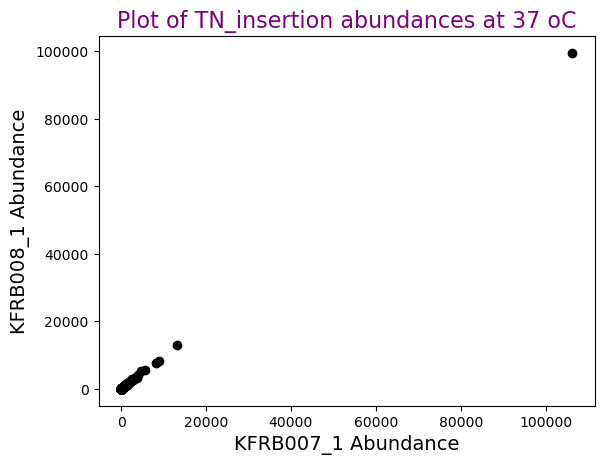

In [14]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB007_1'
y_column = 'KFRB008_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB007_1 Abundance', fontsize=14)
plt.ylabel('KFRB008_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances at 37 oC', fontsize=16, color='purple')
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("fitness_of_TN_abundances_01_03_2024_37oC.png", dpi=600, bbox_inches='tight')
plt.show()

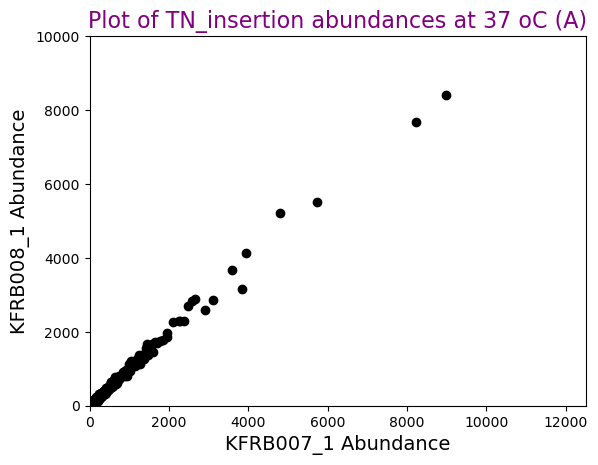

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB007_1'
y_column = 'KFRB008_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB007_1 Abundance', fontsize=14)
plt.ylabel('KFRB008_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances at 37 oC (A)', fontsize=16, color='purple')

# Adjust the x and y-axis scale ranges
plt.xlim(0, 12500)  # Adjust the range for the x-axis
plt.ylim(0, 10000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)

#plt.savefig("fitness_of_TN_abundances_03_01_2024_37oC_1a.png", dpi=600, bbox_inches='tight')
plt.show()


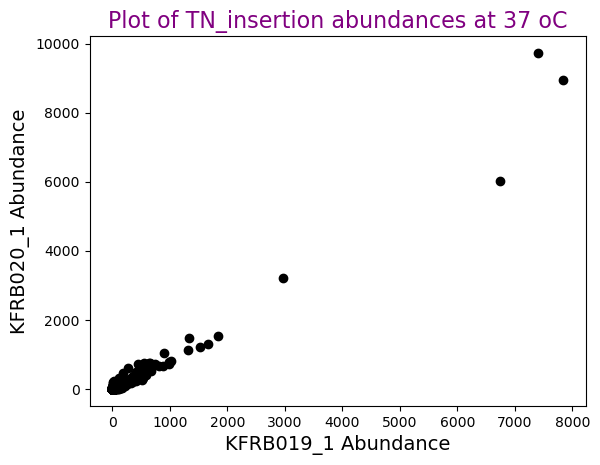

In [16]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB019_1'
y_column = 'KFRB020_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB019_1 Abundance', fontsize=14)
plt.ylabel('KFRB020_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances at 37 oC', fontsize=16, color='purple')
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("fitness_of_TN_abundances_01_03_2024_37oC.png", dpi=600, bbox_inches='tight')
plt.show()

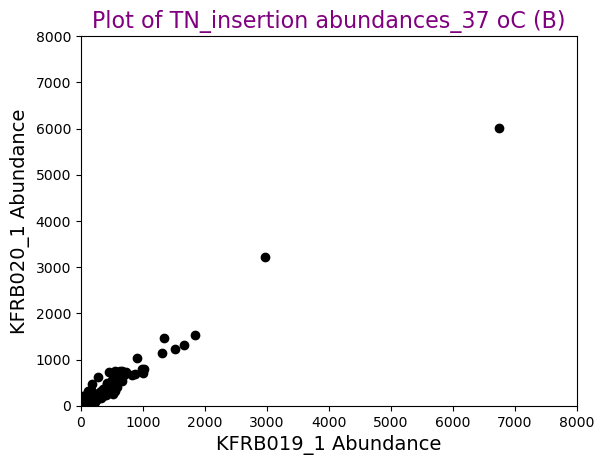

In [17]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB019_1'
y_column = 'KFRB020_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB019_1 Abundance', fontsize=14)
plt.ylabel('KFRB020_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_37 oC (B)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 8000)  # Adjust the range for the x-axis
plt.ylim(0, 8000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("fitness_of_TN_abundances_03_01_2024_45oC_1a.png", dpi=600, bbox_inches='tight')
plt.show()

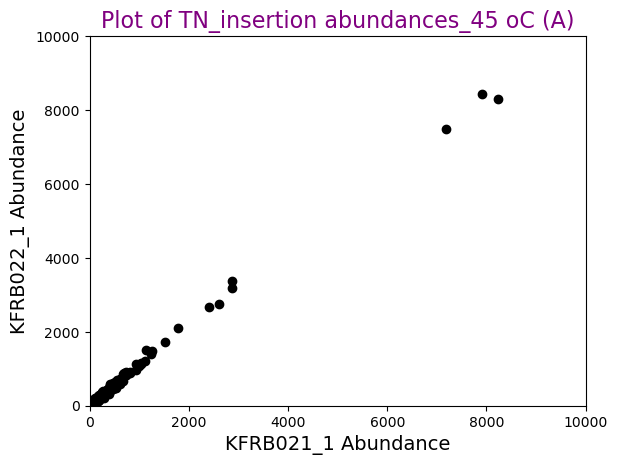

In [18]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB021_1'
y_column = 'KFRB022_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB021_1 Abundance', fontsize=14)
plt.ylabel('KFRB022_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_45 oC (A)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 10000)  # Adjust the range for the x-axis
plt.ylim(0, 10000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("fitness_of_TN_abundances_03_01_2024_45oC_1a.png", dpi=600, bbox_inches='tight')
plt.show()

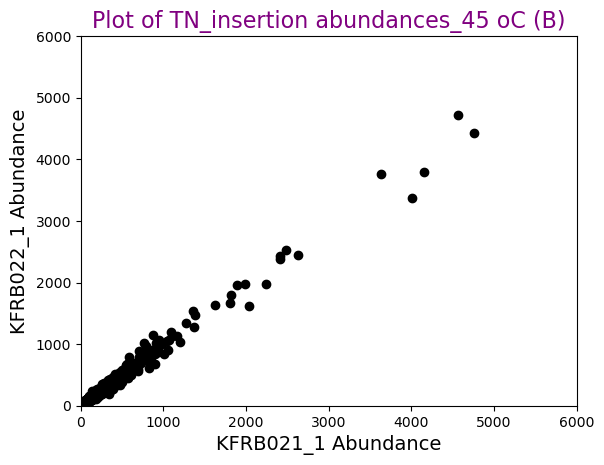

In [19]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB023_1'
y_column = 'KFRB024_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB021_1 Abundance', fontsize=14)
plt.ylabel('KFRB022_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_45 oC (B)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 6000)  # Adjust the range for the x-axis
plt.ylim(0, 6000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("fitness_of_TN_abundances_03_01_2024_45oC_1a.png", dpi=600, bbox_inches='tight')
plt.show()

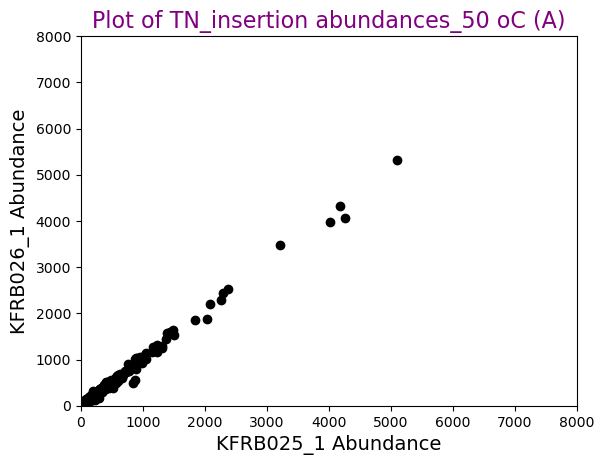

In [20]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt
x_column = 'KFRB025_1'
y_column = 'KFRB026_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB025_1 Abundance', fontsize=14)
plt.ylabel('KFRB026_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_50 oC (A)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 8000)  # Adjust the range for the x-axis
plt.ylim(0, 8000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("fitness_of_TN_abundances_03_01_2024_45oC_1a.png", dpi=600, bbox_inches='tight')
plt.show()

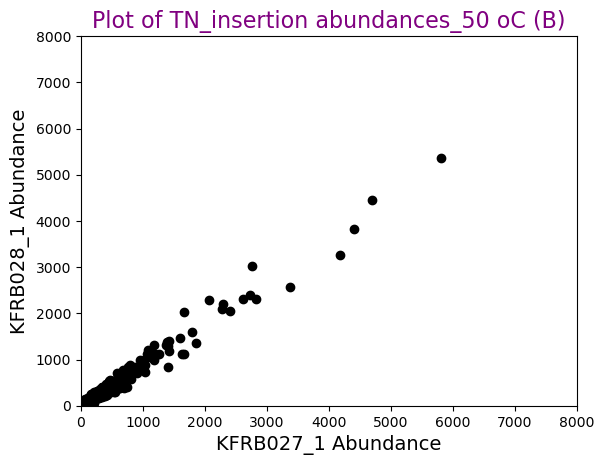

In [21]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/digestion_time_optimization_June_07_2024/Barseq_with_combined_digestion_time/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_06_11_2024/poolCount.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB027_1'
y_column = 'KFRB028_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('KFRB027_1 Abundance', fontsize=14)
plt.ylabel('KFRB028_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_50 oC (B)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 8000)  # Adjust the range for the x-axis
plt.ylim(0, 8000)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("fitness_of_TN_abundances_03_01_2024_45oC_1a.png", dpi=600, bbox_inches='tight')
plt.show()

## to normalize the Barseq pool count file based on the number of reads obtained

#### normalization based on individual sample

In [ ]:
import pandas as pd

# Load the count file into a DataFrame
count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/poolCount.txt'
df = pd.read_csv(count_file_path, sep='\t')

# Calculate the total counts for each replicate
df['Total_Count_KFRB007_1'] = df['KFRB007_1'].sum()
df['Total_Count_KFRB008_1'] = df['KFRB008_1'].sum()
df['Total_Count_KFRB019_1'] = df['KFRB019_1'].sum()
df['Total_Count_KFRB020_1'] = df['KFRB020_1'].sum()
df['Total_Count_KFRB021_1'] = df['KFRB021_1'].sum()
df['Total_Count_KFRB022_1'] = df['KFRB022_1'].sum()
df['Total_Count_KFRB023_1'] = df['KFRB023_1'].sum()
df['Total_Count_KFRB024_1'] = df['KFRB024_1'].sum()
df['Total_Count_KFRB025_1'] = df['KFRB025_1'].sum()
df['Total_Count_KFRB026_1'] = df['KFRB026_1'].sum()
df['Total_Count_KFRB027_1'] = df['KFRB027_1'].sum()
df['Total_Count_KFRB028_1'] = df['KFRB028_1'].sum()

# Normalize counts for each replicate by dividing by its own Total_Count
df['KFRB007_1'] = df['KFRB007_1'] / df['Total_Count_KFRB007_1']
df['KFRB008_1'] = df['KFRB008_1'] / df['Total_Count_KFRB008_1']
df['KFRB019_1'] = df['KFRB019_1'] / df['Total_Count_KFRB019_1']
df['KFRB020_1'] = df['KFRB020_1'] / df['Total_Count_KFRB020_1']
df['KFRB021_1'] = df['KFRB021_1'] / df['Total_Count_KFRB021_1']
df['KFRB022_1'] = df['KFRB022_1'] / df['Total_Count_KFRB022_1']
df['KFRB023_1'] = df['KFRB023_1'] / df['Total_Count_KFRB023_1']
df['KFRB024_1'] = df['KFRB024_1'] / df['Total_Count_KFRB024_1']
df['KFRB025_1'] = df['KFRB025_1'] / df['Total_Count_KFRB025_1']
df['KFRB026_1'] = df['KFRB026_1'] / df['Total_Count_KFRB026_1']
df['KFRB027_1'] = df['KFRB027_1'] / df['Total_Count_KFRB027_1']
df['KFRB028_1'] = df['KFRB028_1'] / df['Total_Count_KFRB028_1']

# Save the normalized count file
normalized_count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.csv'
df.to_csv(normalized_count_file_path, index=False)


### this is the normalization that worked with the right result

In [ ]:
import pandas as pd

# Load the count file into a DataFrame
count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/poolCount.txt'
df = pd.read_csv(count_file_path, sep='\t')

# Calculate the total counts for each replicate
df['Total_Count_KFRB007_1'] = df['KFRB007_1'].sum()
df['Total_Count_KFRB008_1'] = df['KFRB008_1'].sum()
df['Total_Count_KFRB019_1'] = df['KFRB019_1'].sum()
df['Total_Count_KFRB020_1'] = df['KFRB020_1'].sum()
df['Total_Count_KFRB021_1'] = df['KFRB021_1'].sum()
df['Total_Count_KFRB022_1'] = df['KFRB022_1'].sum()
df['Total_Count_KFRB023_1'] = df['KFRB023_1'].sum()
df['Total_Count_KFRB024_1'] = df['KFRB024_1'].sum()
df['Total_Count_KFRB025_1'] = df['KFRB025_1'].sum()
df['Total_Count_KFRB026_1'] = df['KFRB026_1'].sum()
df['Total_Count_KFRB027_1'] = df['KFRB027_1'].sum()
df['Total_Count_KFRB028_1'] = df['KFRB028_1'].sum()

# Normalize counts for each replicate by dividing by its own Total_Count
df['KFRB007_1'] = df['KFRB007_1'] / df['Total_Count_KFRB007_1']
df['KFRB008_1'] = df['KFRB008_1'] / df['Total_Count_KFRB008_1']
df['KFRB019_1'] = df['KFRB019_1'] / df['Total_Count_KFRB019_1']
df['KFRB020_1'] = df['KFRB020_1'] / df['Total_Count_KFRB020_1']
df['KFRB021_1'] = df['KFRB021_1'] / df['Total_Count_KFRB021_1']
df['KFRB022_1'] = df['KFRB022_1'] / df['Total_Count_KFRB022_1']
df['KFRB023_1'] = df['KFRB023_1'] / df['Total_Count_KFRB023_1']
df['KFRB024_1'] = df['KFRB024_1'] / df['Total_Count_KFRB024_1']
df['KFRB025_1'] = df['KFRB025_1'] / df['Total_Count_KFRB025_1']
df['KFRB026_1'] = df['KFRB026_1'] / df['Total_Count_KFRB026_1']
df['KFRB027_1'] = df['KFRB027_1'] / df['Total_Count_KFRB027_1']
df['KFRB028_1'] = df['KFRB028_1'] / df['Total_Count_KFRB028_1']
# Save the normalized count file
normalized_count_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.csv'
df.to_csv(normalized_count_file_path, index=False)


##### To make the fitness abundance agaian using the normalized values

In [ ]:
import pandas as pd

# Load the CSV file
csv_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.csv'
df = pd.read_csv(csv_file_path)

# Save the DataFrame to a text file (txt)
txt_file_path = '/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.txt'
df.to_csv(txt_file_path, sep='\t', index=False)


In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB007_1'
y_column = 'KFRB008_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB007_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB008_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_37 oC_normalized (A)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.04)  # Adjust the range for the x-axis
plt.ylim(0, 0.04)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_01_09_2024_37oC_Normalized_1.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB019_1'
y_column = 'KFRB020_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB019_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB020_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_37 oC_normalized (B)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.02)  # Adjust the range for the x-axis
plt.ylim(0, 0.02)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_01_09_2024_37oC_Normalized_1.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB021_1'
y_column = 'KFRB022_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB021_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB022_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_45 oC_normalized (A)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.02)  # Adjust the range for the x-axis
plt.ylim(0, 0.02)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_01_09_2024_37oC_Normalized_1.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB023_1'
y_column = 'KFRB024_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB023_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB024_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_45 oC_normalized (B)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.02)  # Adjust the range for the x-axis
plt.ylim(0, 0.02)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_01_09_2024_37oC_Normalized_1.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB025_1'
y_column = 'KFRB026_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB025_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB026_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_50 oC_normalized (A)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.02)  # Adjust the range for the x-axis
plt.ylim(0, 0.02)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_01_09_2024_37oC_Normalized_1.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Load the data from the CSV file into a DataFrame
df = pd.read_csv('/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Sequencing_with_the_13k_mutants/for_analysis/TNSeq_13k_mutants_mapping_output/TNSeq_barseq_outputs_using_combined_tnseq_poolfile_all_temp_05_23_2024/normalized_barseq_pool_counts_05_28_2024.txt', sep='\t')

# Select the columns you want to use for the scatter plot
x_column = 'KFRB027_1'
y_column = 'KFRB028_1'

# Create a scatter plot using the selected columns
plt.scatter(df[x_column], df[y_column], color='black')
plt.xlabel('Normalized_KFRB027_1 Abundance', fontsize=14)
plt.ylabel('Normalized_KFRB028_1 Abundance', fontsize=14)
plt.title('Plot of TN_insertion abundances_45 oC_normalized (B)', fontsize=16, color='purple')
# Adjust the x and y-axis scale ranges
plt.xlim(0, 0.02)  # Adjust the range for the x-axis
plt.ylim(0, 0.02)  # Adjust the range for the y-axis

# Optionally, add grid lines
#plt.grid(True)
#plt.grid(True)  # Optionally, add grid lines
#plt.savefig("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/Barseq_Temp_study_11_04_2023/histogram_plots/fitness_of_TN_abundances_01_09_2024_37oC_Normalized_1.png", dpi=600, bbox_inches='tight')
plt.show()